# <코로나 전후 미래교육 정책 변화 분석>

# 데이터 준비

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/MyDrive/Colab Notebooks/textmining/final_data')

Mounted at /content/gdrive


In [ ]:
!pip install customized_konlpy
!pip3 install pickle5 
!pip install git+https://github.com/haven-jeon/PyKoSpacing.git
!pip install pyLDAvis==3.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 12.2 MB/s 


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline 
import re
import pandas as pd
from tqdm import tqdm
from collections import Counter
import numpy as np

In [ ]:
import pickle5 as pickle 
with open("predata.pkl","rb") as fr:
    pretext = pickle.load(fr)

with open("postdata.pkl","rb") as fr:
    posttext = pickle.load(fr)

# 데이터 탐색

## 1.1. 데이터 살펴보기

In [ ]:
pretext #코로나 이전 데이터

,id,doc
0,1,년 제 차 사회 관계장관회의 개최 담당 부서 교육부 사회 정책협력관실 과장 김우정 ...
1,2,수학 공감! 수학 교육 성과 발표회 및 시상식 개최 담당 부서 교육부 융합교육지원팀...
2,3,동정 자료 이준식 부총리 전국대학 총장들과 만나 담당 부서 교육부 대학 정책과 과장...
3,4,국가진로교육센터 개소식 개최 담당 부서 교육부 진로교육 정책과 과장 문승태 사무관 ...
4,5,년 더욱 새로워진 로 내신과 수능을 준비하세요 담당 부서 ; 교육부 이러닝과 과장 ...
...,...,...
592,593,제 차 산업혁명과 미래교육 실천방안 제 차 산업혁명과 미래교육 실천방안 박 승 재 ...
593,594,년 다문화교육 지원계획 . . 교육기회보장과 목 차 . 추진 배경 및 경과 . 다문...
594,595,여백 학교 교육에서 메이커 교육의 효과적 실행을 위한 논의점 배경 및 필요성 차 산...
595,596,차례 제목 차례 요 약 제 장 서 론 제 장 차 산업혁명에 대응한 핵심역량 강화의 ...


In [ ]:
posttext #코로나 이후 데이터

,id,doc
0,1,년 교육부 신년사 존경하는 국민 여러분 경자년 새해가 밝았습니다. 국민 여러분 새해...
1,2,검정 역사교과서 집필진 자율성 존중해 다양한 내용으로 서술 교육부는 검정 역사교과서...
2,3,동정 자료 유은혜 부총리 년 교육계 신년교례회 참석 담당과 교육협력과 과 장 김 석...
3,4,함께 만드는 학교 평화? 통일교육 공감한마당 개최 담당과 민주시민교육과 과 장 신두...
4,5,동정 자료 교육부 전국시도교육감협의회 신년 간담회 개최 담당과 정책협력팀 팀장 양신...
...,...,...
752,753,학생 간의 학력 격차 확대 학습의 질 저하 평가의 공정성 유지 어려움 등에 대한 온...
753,754,. . . . . . . . . . . . . . . . . . . . ...
754,755,년 국가수 학생 김수환 총신 학교 류기곤 고려 학교 김경아 북 학교 조규복 한국교육...
755,756,


## 1.2. 데이터 개수, 결측치 및 중복 데이터 확인

In [ ]:
pretext.info()
posttext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 597 entries, 0 to 596
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      597 non-null    int64 
 1   doc     597 non-null    object
dtypes: int64(1), object(1)
memory usage: 9.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757 entries, 0 to 756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      757 non-null    int64 
 1   doc     757 non-null    object
dtypes: int64(1), object(1)
memory usage: 12.0+ KB


In [ ]:
# 중복 데이터 개수 - 코로나 이전
pretext['doc'].nunique()

545

In [ ]:
# 중복 데이터 확인 
pretext[pretext.duplicated(['doc'], keep=False)].sort_values(by='doc')[:30]

,id,doc
596,597,
549,550,
518,519,
505,506,
484,485,
566,567,
366,367,개정 누리과정 확정 발표 담당 부서 교육부 유아교육정책과 과장 이지은 연구관 문 복...
364,365,개정 누리과정 확정 발표 담당 부서 교육부 유아교육정책과 과장 이지은 연구관 문 복...
285,286,고졸 취업 지원 확대 지역 인재 급 채용도 대폭 정부가 직업계고를 나와 고졸로 취업...
283,284,고졸 취업 지원 확대 지역 인재 급 채용도 대폭 정부가 직업계고를 나와 고졸로 취업...


In [ ]:
# 중복 데이터 개수 - 코로나 이후
posttext['doc'].nunique()

471

In [ ]:
# 중복 데이터 확인
posttext[posttext.duplicated(['doc'], keep=False)].sort_values(by='doc')[:30]

,id,doc
755,756,
692,693,
724,725,
736,737,
605,606,
361,362,? 교육과정 심의회 규정? 일부개정안 국무회의 통과 담당과 교육과정 정책과 과 장 ...
363,364,? 교육과정 심의회 규정? 일부개정안 국무회의 통과 담당과 교육과정 정책과 과 장 ...
365,366,? 교육과정 심의회 규정? 일부개정안 국무회의 통과 담당과 교육과정 정책과 과 장 ...
370,371,? 교육과정 심의회 규정? 일부개정안 국무회의 통과 담당과 교육과정 정책과 과 장 ...
479,480,? 전국 장애학생 진로드림 페스티벌? 개최 ? 전국 장애학생 진로드림 페스티벌? 개...


In [ ]:
# 중복된 데이터 삭제 - 코로나 이전
pretext = pretext.drop_duplicates(subset = ['doc'], keep='first')
len(pretext)

545

In [ ]:
# 중복데이터 삭제 - 코로나 이후 
posttext = posttext.drop_duplicates(subset = ['doc'], keep='first')
len(posttext)

471

# 데이터 전처리 
 * 노이즈 제거 
 * 띄어쓰기 교정 - pykospacing
 * 사용자 사전 추가 및 불용어 제거
 * 명사만 추출  

## 2.1. 데이터 정제

### 2.1.1.노이즈 제거

In [ ]:
# 한글 : . ! ? 공백 아닌 것들 모두 공백으로 변환. 이후에 공백 2개 이상은 하나로 변환. -코로나 이전 데이터
import re
pretext['doc'] = pretext['doc'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣;.!? ]"," ")
pretext['doc'] = pretext['doc'].str.replace('[\s]{2,}', " ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [ ]:
# 코로나 이후 데이터에도 노이즈 제거 동일하게 적용
posttext['doc'] = posttext['doc'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣;.!? ]"," ")
posttext['doc'] = posttext['doc'].str.replace('[\s]{2,}', " ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

### 2.2.2. 띄어쓰기 교정

In [ ]:
from pykospacing import Spacing
tqdm.pandas()

spacing = Spacing()

pretext['doc'] = pretext['doc'].progress_apply(spacing)

100%|██████████| 545/545 [1:42:26<00:00, 11.28s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# 코로나 이후 데이터

posttext['doc'] = posttext['doc'].progress_apply(spacing)

100%|██████████| 471/471 [27:26<00:00,  3.50s/it]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# 피클로 저장 

with open("spacedpredata.pickle","wb") as f:
  pickle.dump(pretext, f)

with open("spacedpostdata.pickle","wb") as f:
  pickle.dump(posttext, f)

In [ ]:
with open("spacedpredata1.pickle","rb") as fr:
    pretext = pickle.load(fr)

In [ ]:
pretext.head()

,id,doc
0,1,년 제 차 사회 관계장관회의 개최 담당 부서 교육부 사회 정책협력관실 과장 김우정 ...
1,2,수학 공감! 수학 교육 성과 발표회 및 시상식 개최 담당 부서 교육부 융합교육지원팀...
2,3,동정 자료 이준식 부총리 전국대학 총장들과 만나 담당 부서 교육부 대학 정책과 과장...
3,4,국가진로교육센터 개소식 개최 담당 부서 교육부 진로교육 정책과 과장 문승태 사무관 ...
4,5,년 더욱 새로워진 로 내신과 수능을 준비하세요 담당 부서 ; 교육부 이러닝과 과장 ...


### 2.2.3. okt 사용자사전 추가, 명사 추출 및 빈도분석
 * 교육 분야에서 의미 있는 단어를 하나의 명사로 인식하도록 사용자 사전 추가
 * 불용어 사전 구성: 교육 관련 데이터셋에서 연구자가 기존에 가지고 있던 불용어 사전, 현 데이터셋 빈도분석 결과 상위 단어에서 의미 없게 나온 단어 추가. 예) ['첫째','둘째','샛째','도록','또한','때문','까지','대한','통한', '대해', '요하', '이나', '면서', '우리나라']

In [ ]:
from ckonlpy.tag import Twitter

tagpos= Twitter()
tagpos.add_dictionary(['프로젝트','협의체'
,'교육청','교육지원청','인공지능','원격수업','원격학습','리터러시'
,'에듀테크','그린스마트','블렌디드','성취수준','성취기준','핵심역량'
,'누리과정','교육정책','과정중심','혁신학교','학교급','이러닝','데이터'
,'사교육','교수학습','학습자','돌봄','코로나','전문가','고등교육', '교원양성','재교육'
,'대통령','교육과정','고등교육','학제','학제개편','맞벌이','예비교사','컴퓨터','리터 러시'
,'불평등','교원양성','평생학습','대입제도','입시','하드웨어','소프트웨어','학제','정보통신'
,'평생학습','평생교육','교육복지','글로벌','빅데이터','방과후','광역시','머신러닝'], 'Noun') 

/usr/local/lib/python3.7/dist-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [ ]:
stopwords = ['첫째','둘째','샛째','도록','교육','학교','학생','정책','지원','학습','교사','또한','때문','까지','대한','분석','국가','내용','관련','한국','통해','위해','경우','통한','대해','요하','이나','면서','우리나라',\
             '어져','넷째','래서','그것','여서','거의','로서','후의','더하여','하나','따라서','이후','부터','린다','어져','교하면','넷째','그냥','없는','있는','없다','같은','이건','입니다','없고','때문',\
             '이나','보지','인지','아닌','처럼','뭔가','그런','가지','아니고','이지','아무','위해','마다','같아요','마다','대해','마라','갈수록','있을','있는데','있을','있지만','있어','없어서','없어','있어서','없었다',\
             '대로','그런지','있음','없음','있다는','같네요','수도','저런','있게','라서','없을','스러운','같습니다','같아','하자','없을','그렇고','아니다','있다','그렇다','정말','같다','이다','해도','안되다','해도',\
             '그냥','어서','어요','래서','부터','위해','어가','더니','어가','더니','관련','래서','대로','여서','을지','어요','아이','우리','부분','려고','관련','고요','아보','면서','해주','안녕','조금','보고','보시',\
             '주신','어보','모두','다가','드립','별로','동안','여주','거나','보기','저희','다시','주시','아주','나타','붙이','보이','하라','구들','았습니다','이주','디스','주의','고하','려면','스텔라','기도','아하',\
             '서요','계시','싸라기','정해','성하','이면','리움','라며','만큼','같은데','위해','관련','도록','통해','나타','대한','경우','로부터','서도','이희','다섯','것임','구의','아래'] 

In [ ]:
# 불용어 제거하고 1글자 제외, 명사만 추출 - 코로나 이전

from konlpy.tag import Okt
from tqdm import tqdm
okt = Okt()

def my_tokenizer(doc):
    return [token for token, pos in tagpos.pos(doc, norm=True, stem=True) if pos in ['Noun'] and (len(token) > 1)]

pre_train = []
for doc in tqdm(pretext['doc']):
    tokenized_doc = my_tokenizer(doc)
    stopwords_removed = [word for word in tokenized_doc if word not in stopwords]
    pre_train.append(stopwords_removed)

100%|██████████| 545/545 [09:48<00:00,  1.08s/it]


In [ ]:
# 불용어 제거하고 1글자 제외, 명사만 추출 - 코로나 이후

from konlpy.tag import Okt
from tqdm import tqdm
okt = Okt()

def my_tokenizer(doc):
    return [token for token, pos in tagpos.pos(doc, norm=True, stem=True) if pos in ['Noun'] and (len(token) > 1)]

post_train = []
for doc in tqdm(posttext['doc']):
    tokenized_doc = my_tokenizer(doc)
    stopwords_removed = [word for word in tokenized_doc if word not in stopwords]
    post_train.append(stopwords_removed)

100%|██████████| 471/471 [02:54<00:00,  2.71it/s]


In [ ]:
#빈도수 상위 500개의 단어를 출력 - 코로나 이전

pos_count = dict()

for rv in pre_train:
    for token in rv:
        pos_count[token] = pos_count.get(token, 0) + 1   
        
sorted_pos_count = sorted(pos_count, key=pos_count.get, reverse=True)

print('1. pre covid')
print('- Num of used words:', len(pos_count))
print("- Top 10 high frequency words:")
for key in sorted_pos_count[:500]: 
    print(f'{key}: {pos_count[key]}', end=', ')

1. pre covid
- Num of used words: 31684
- Top 10 high frequency words:
직업: 28572, 역량: 28154, 교육과정: 24486, 평가: 23440, 개발: 21354, 운영: 20223, 진로: 19423, 필요: 18711, 활용: 17705, 대학: 17086, 미래: 16209, 청소년: 16043, 지역: 15467, 사업: 14545, 능력: 14524, 기술: 14333, 변화: 14094, 활동: 14021, 조사: 13947, 수업: 13702, 교과: 13456, 방안: 13266, 결과: 13233, 과정: 12584, 훈련: 12255, 정보: 12137, 혁신: 11817, 문제: 11780, 참여: 11530, 다양: 11412, 제공: 11349, 자료: 10955, 관리: 10944, 강화: 10841, 교육부: 10820, 제시: 10774, 수준: 10703, 기관: 10596, 추진: 10562, 학년: 10147, 기반: 9939, 계획: 9875, 프로그램: 9866, 정부: 9616, 중심: 9291, 환경: 9082, 개선: 9032, 구축: 8634, 디지털: 8602, 체제: 8525, 사례: 8391, 체계: 8328, 과제: 8296, 방향: 8144, 고등학교: 8129, 구성: 8094, 산업: 8049, 분야: 7853, 가능: 7801, 요구: 7770, 제도: 7707, 대상: 7422, 기업: 7125, 현장: 7055, 시스템: 7024, 포함: 7009, 확대: 6929, 협력: 6820, 지식: 6817, 수행: 6756, 서비스: 6709, 기준: 6696, 역할: 6691, 인식: 6686, 구분: 6668, 통합: 6616, 기능: 6546, 영역: 6496, 시간: 6487, 성과: 6468, 경험: 6462, 방식: 6453, 상황: 6336, 이상: 6265, 응답: 6259, 교원: 6258, 일반: 6225, 특성: 6222

In [ ]:
#빈도수 상위 500개의 단어를 출력 - 코로나 이후

pos_count = dict()

for rv in post_train:
    for token in rv:
        pos_count[token] = pos_count.get(token, 0) + 1   
        
sorted_pos_count = sorted(pos_count, key=pos_count.get, reverse=True)

print('1. post covid')
print('- Num of used words:', len(pos_count))
print("- Top 10 high frequency words:")
for key in sorted_pos_count[:500]: 
    print(f'{key}: {pos_count[key]}', end=', ')

1. pre covid
- Num of used words: 17514
- Top 10 high frequency words:
운영: 8173, 활용: 6432, 평가: 5846, 대학: 5547, 디지털: 5351, 수업: 5012, 사업: 4901, 개발: 4838, 필요: 4828, 교육과정: 4479, 추진: 4308, 역량: 3950, 교육부: 3949, 방안: 3713, 온라인: 3693, 지역: 3584, 구축: 3420, 결과: 3385, 혁신: 3383, 정보: 3212, 계획: 3199, 환경: 3072, 다양: 3064, 미래: 3053, 기술: 3002, 강화: 2997, 기관: 2982, 제공: 2911, 과정: 2899, 체제: 2897, 교과: 2891, 개선: 2879, 자료: 2797, 활동: 2775, 관리: 2670, 참여: 2659, 중심: 2629, 변화: 2575, 조사: 2507, 가능: 2472, 교원: 2392, 확대: 2385, 문제: 2383, 청소년: 2379, 기준: 2369, 통합: 2357, 기반: 2352, 분야: 2284, 수준: 2241, 사용: 2208, 체계: 2175, 제도: 2154, 제시: 2140, 마련: 2132, 대상: 2128, 시스템: 2122, 정부: 2090, 협력: 2043, 구성: 2036, 대응: 2029, 능력: 2019, 콘텐츠: 1993, 프로그램: 1972, 교과서: 1941, 코로나: 1932, 지속: 1906, 전환: 1903, 사례: 1891, 주요: 1869, 상황: 1867, 산업: 1848, 공간: 1836, 방향: 1831, 직업: 1804, 현장: 1785, 센터: 1770, 의견: 1770, 서비스: 1724, 양성: 1717, 학습자: 1698, 교육청: 1697, 과제: 1693, 인식: 1667, 예산: 1651, 효과: 1644, 성과: 1639, 사이버: 1638, 방식: 1627, 연수: 1606, 요구: 1606, 실시: 1598, 포함:

# WORD2VEC
* Gensim word2vec, fasttext 이용하여 코로나 이전과 이후 데이터의 단어 임베딩
* vector size / skip gram, cbow 를 조정하며 결과 확인
* fasttext, vector size 200, skip gram 모델 사용

In [ ]:
!pip install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 33.9 MB/s 


In [ ]:
import pickle5 as pickle

In [ ]:
import pickle5 as pickle 
with open("pre_train.pickle","rb") as fr:
    pretext = pickle.load(fr)

with open("post_train.pickle","rb") as fr:
    posttext = pickle.load(fr)

In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

#model1 = Word2Vec(pretext, min_count= 100, size = 300, window= 5)
#model1 = Word2Vec(pretext, min_count= 100, size = 200, window= 5, sg=1)

model3 = FastText(pretext, min_count= 100, size = 200, window= 5, sg=1)

In [ ]:
#model2 = Word2Vec(posttext, min_count= 100, size = 200, window= 5, sg=1)

model4 = FastText(posttext, min_count= 100, size = 200, window= 5, sg=1)

In [ ]:
def similarkeywords(keyword) :
  wvlist = model1.wv.most_similar(keyword)
  ftlist = model3.wv.most_similar(keyword)
  wvlist = pd.DataFrame(wvlist)
  ftlist = pd.DataFrame(ftlist)
  dfkeyword = pd.concat([wvlist, ftlist],axis=1)
  dfkeyword.columns= ['wv', keyword,'ft', keyword]
  return dfkeyword

In [ ]:
simdf = pd.concat([similarkeywords('돌봄'), similarkeywords('고등교육'),similarkeywords('인구'),similarkeywords('지역'),similarkeywords('학제'),similarkeywords('교원'),similarkeywords('디지털'),similarkeywords('평생'),similarkeywords('복지')],axis=1)

In [ ]:
simdf.to_csv('pre200sg.csv')

In [ ]:
def similarkeywords(keyword) :
  wvlist = model2.wv.most_similar(keyword)
  ftlist = model4.wv.most_similar(keyword)
  wvlist = pd.DataFrame(wvlist)
  ftlist = pd.DataFrame(ftlist)
  dfkeyword = pd.concat([wvlist, ftlist],axis=1)
  dfkeyword.columns= ['wv', keyword,'ft', keyword]
  return dfkeyword

In [ ]:
simpost = pd.concat([similarkeywords('돌봄'), similarkeywords('대입'),similarkeywords('지역'),similarkeywords('고등교육'),similarkeywords('인구'), similarkeywords('학제'),similarkeywords('교원'),similarkeywords('디지털'),similarkeywords('평생'),similarkeywords('복지')],axis=1)

In [ ]:
simpost.to_csv('post200sg.csv')

# Kmeans
* inertias 응집도 판별로 적정 토픽 수 탐색
* 결정된 적정 토픽 수에 맞게 neighbor 단어 수 설정
* pre covid : 17개 post covid : 13개 군집 
 


## 4.1.코로나 이전

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


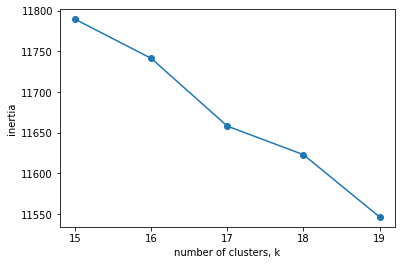

In [ ]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

word_vectors = model3.wv.syn0

ks = range(15,20)
inertias = []
for k in ks:
  model = KMeans(n_clusters=k)
  model.fit(word_vectors)
  inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
# syn0의 행 수는 모델 어휘의 단어 수
# 열 수는 2부에서 설정한 특징 벡터의 크기
# model.wv.syn0.shape

word_vectors = model3.wv.syn0 # 어휘의 feature vector
num_clusters = int(word_vectors.shape[0]/160) # topic 수 17-18사이 적정값 맞추기 위해 어휘수 결정, 단어 주위 Neighbor 16개 단어로 
print(num_clusters)
num_clusters = int(num_clusters)

kmeans_clustering = KMeans(n_clusters=num_clusters,max_iter=5,init='k-means++')
idx = kmeans_clustering.fit_predict(word_vectors)

idx = list(idx)
names = model4.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


17


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(word_vectors)

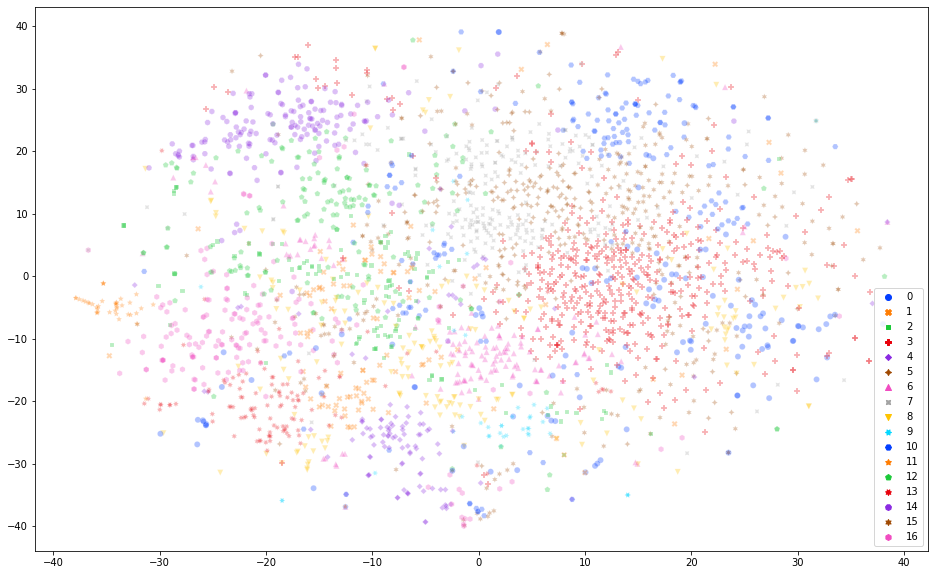

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
one = tsne_results[:,0]
two = tsne_results[:,1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x= one, y= two,
    hue= idx,
    style= idx,
    palette=sns.color_palette("bright", 17),
    legend="full", 
    alpha=0.3
)


In [ ]:
for c in range(num_clusters):
    # 클러스터 번호를 출력
   
    print("\ncluster {}".format(c))
    
    words = []
    cluster_values = list(word_centroid_map.values())
    for i in range(len(cluster_values)):
        if (cluster_values[i] == c):
            words.append(list(word_centroid_map.keys())[i])            
    print(words)


cluster 0
['조사', '교원', '코로나', '원격수업', '기회', '제안', '설치', '중요', '바탕', '점검', '글로벌', '소규모', '발굴', '도서', '억원', '법률', '하위', '계층', '측정', '직무', '지향', '동시', '등교', '제기', '취약', '언어', '공무원', '고등', '선발', '토대', '대안', '는가', '불어', '내외', '가이드라인', '보건', '생애', '물리', '체육', '접속', '추천', '가구', '거점', '원인', '습득', '전통', '업체', '서버', '모집', '전임', '어디', '독립', '노동', '교통', '추이', '장학금', '정신', '음악', '경기도', '공부', '비즈니스', '실질', '저학년']

cluster 1
['필요', '방안', '기술', '현장', '역할', '인력', '자격', '선정', '시설', '해결', '문항', '기업', '확보', '학부모', '위원회', '국민', '확인', '고교', '규정', '실행', '공동체', '보급', '자원', '원격교육', '유지', '학기', '자기', '무엇', '집중', '제한', '규제', '시험', '배경', '직접', '수집', '출하', '러닝', '자유', '시각', '교과목', '전담', '도시', '지적', '일정', '유은혜', '대면', '원칙', '원리', '반적', '대부분', '졸업', '지원이', '서론', '초점', '자치', '에너지', '현행', '협약', '조건', '반면', '수강', '제품', '교육자', '단순', '대한민국', '미흡', '만원', '일본', '사고력', '전반', '양질', '동영상', '수록', '개학', '일상', '입장', '수능', '연령', '자가', '대구', '뉴스', '방지', '상의', '박사', '발행', '게임', '적응', '수도권', '비중', '양하', '지수', '교원양성', '기후', '중인', '세

## 4.2. 코로나 이후

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


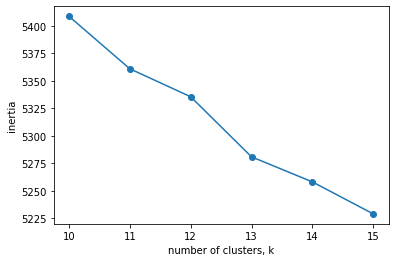

In [ ]:
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

word_vectors = model4.wv.syn0

ks = range(10,16)
inertias = []
for k in ks:
  model = KMeans(n_clusters=k)
  model.fit(word_vectors)
  inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
from sklearn.cluster import KMeans
# syn0의 행 수는 모델 어휘의 단어 수
# 열 수는 2부에서 설정한 특징 벡터의 크기
# model.wv.syn0.shape

word_vectors = model4.wv.syn0 # 어휘의 feature vector
num_clusters = int(word_vectors.shape[0]/110) # topic 수 11-13사이 적정값 맞추기 위해 어휘수 결정, 단어 주위 Neighbor 11개 단어로 
print(num_clusters)
num_clusters = int(num_clusters)

kmeans_clustering = KMeans(n_clusters=num_clusters,max_iter=5,init='k-means++')
idx = kmeans_clustering.fit_predict(word_vectors)

idx = list(idx)
names = model4.wv.index2word
word_centroid_map = {names[i]: idx[i] for i in range(len(names))}
 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, perplexity=40, n_iter=3000)
tsne_results = tsne.fit_transform(word_vectors)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
for c in range(num_clusters):
    # 클러스터 번호를 출력
   
    print("\ncluster {}".format(c))
    
    words = []
    cluster_values = list(word_centroid_map.values())
    for i in range(len(cluster_values)):
        if (cluster_values[i] == c):
            words.append(list(word_centroid_map.keys())[i])            
    print(words)



cluster 0
['운영', '개발', '교육과정', '추진', '구축', '강화', '기관', '개선', '관리', '참여', '교원', '확대', '분야', '체계', '마련', '대상', '프로그램', '사례', '현장', '센터', '의견', '양성', '교육청', '성과', '연수', '실시', '포함', '단계', '인력', '전문가', '교수', '수행', '진로', '진행', '선정', '기초', '전문', '활성화', '현황', '단위', '확보', '학부모', '시도', '예술', '맞춤', '공동', '종합', '지도', '수요', '검토', '확산', '준비', '훈련', '협의', '영하', '반영', '우수', '전문성', '강좌', '행정', '담당', '개최', '자체', '인증', '문해', '학급', '실습', '집중', '시기', '민간', '안내', '점검', '여부', '강사', '해외', '예정', '지자체', '중등', '발굴', '실태', '전국', '협업', '담당자', '중점', '중앙', '성교육', '보완', '수렴', '기획', '배치', '성인', '직무', '홍보', '부여', '전담', '개요', '외부', '등교', '일정', '대면', '비대', '그룹', '교직원', '적극', '시범', '산학', '사전', '인문', '연구', '실무', '행사', '관계자', '교육자', '모니터링', '안정', '희망', '명의', '정성', '올해', '실화', '자문', '컨설팅', '면담', '유도', '소속', '유관', '정보보안', '체육', '병행', '단기', '지역별', '방문', '인사', '추천', '권역별', '중인', '공모', '협의체', '교장', '대학생', '시급', '의회', '워크숍', '가칭', '업체', '내부', '토론회', '관리자', '방과', '예비', '방과후', '매치', '고등학생', '매뉴얼', '찬성', '중고', '특화', '무능력', '기부', '제

In [ ]:
kmenaspre = pd.DataFrame(words, columns=['words'])
kmenaspost = pd.DataFrame(words, columns=['words'])

kmeanspre['cluster'] = kmeanspre.index+1
kmeanspost['cluster'] = kmeanspost.index+1

kmeanspre.to_csv('kmeanspre.csv')
kmeanspost.to_csv('kmeanspost.csv')


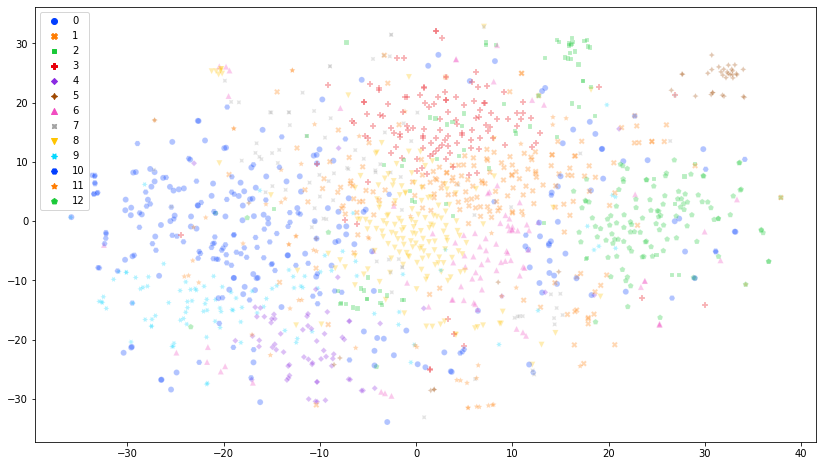

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
one = tsne_results[:,0]
two = tsne_results[:,1]

plt.figure(figsize=(14, 8))
sns.scatterplot(
    x= one, y= two,
    hue= idx,
    style= idx,
    palette=sns.color_palette("bright",13),
    legend="full",
    alpha=0.3
)


# LDA 토픽모델링 
* Gensim 이용하여 코로나 이전과 이후 데이터의 토픽 분류.
* 각각 응집성을 최대로 하는 토픽 수를 선정하고, 시각화.
* 토픽에 해당하는 상위 단어 분포 분석.

## 5.1. 토픽모델링: 코로나 이전

In [ ]:
import pickle as pickle

with open("pre_train.pickle","rb") as fr:
    pre_train = pickle.load(fr)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel
from gensim.models.callbacks import PerplexityMetric
import pyLDAvis
import pyLDAvis.gensim_models as pyLDAvisgensim

### 5.1.1.성능 향상을 위해 bigram과 trigram 이용

In [ ]:
from gensim import corpora
import gensim.models

bigram = gensim.models.Phrases(pre_train, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[pre_train], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

pretrain_bi = []

for i in range(0, len(pre_train)):
    pretrain_bi.append(trigram_mod[bigram_mod[pre_train[i]]])

dictionary = corpora.Dictionary(pretrain_bi)
dictionary.filter_extremes(keep_n=5000, no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(a_pretrain_bi) for a_pretrain_bi in pretrain_bi]

### 5.1.2. coherence 높은 토픽 개수 찾기

[0.3306514413378795] 13
[0.3306514413378795, 0.3223477554005831] 14
[0.3306514413378795, 0.3223477554005831, 0.337475799569229] 15
[0.3306514413378795, 0.3223477554005831, 0.337475799569229, 0.32513715941160204] 16
[0.3306514413378795, 0.3223477554005831, 0.337475799569229, 0.32513715941160204, 0.3207538378740554] 17
[0.3306514413378795, 0.3223477554005831, 0.337475799569229, 0.32513715941160204, 0.3207538378740554, 0.32661913500241646] 18
[0.3306514413378795, 0.3223477554005831, 0.337475799569229, 0.32513715941160204, 0.3207538378740554, 0.32661913500241646, 0.31818153928822085] 19
[0.3306514413378795, 0.3223477554005831, 0.337475799569229, 0.32513715941160204, 0.3207538378740554, 0.32661913500241646, 0.31818153928822085, 0.3309667192458453] 20
[0.3306514413378795, 0.3223477554005831, 0.337475799569229, 0.32513715941160204, 0.3207538378740554, 0.32661913500241646, 0.31818153928822085, 0.3309667192458453, 0.32843835301469465] 21
[0.3306514413378795, 0.3223477554005831, 0.33747579956922

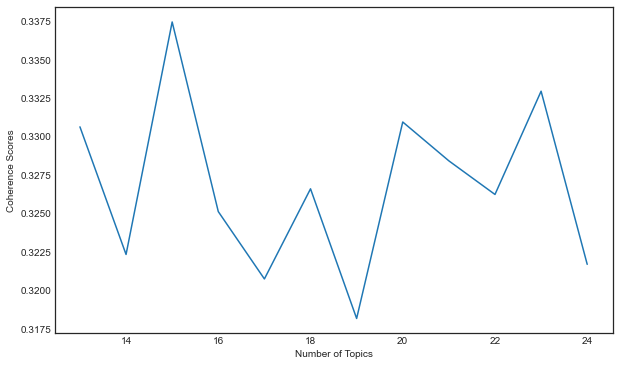

In [ ]:
min_topics, max_topics = 13, 25
coherence_scores=[]
for num_topics in range(min_topics, max_topics):
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model = model, texts=pretrain_bi,dictionary=dictionary)
    coherence_scores.append(coherence.get_coherence())
    print(coherence_scores, num_topics)  


import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

x = [i for i in range(min_topics, max_topics)]

plt.figure(figsize=(10,6))
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.show()

### 5.1.3. 토픽 15개 선정 후 LDA 시각화

In [ ]:
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as pyLDAvisgensim

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=15, passes=5, random_state=7 )

pyLDAvis.enable_notebook()
vis=pyLDAvisgensim.prepare(lda_model, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


### 5.1.4. 토픽 단어 상위 35개 엑셀파일에 저장

In [ ]:
from gensim.models import LdaModel

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=15, passes=5, random_state=7 )
prelda = lda_model.print_topics(num_words=35)
ldamodelpre =pd.DataFrame(prelda)
ldamodelpre.columns =['topic','words']


import re
ldamodelpre['words'] = ldamodelpre['words'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣;!?+ ]"," ")


ldamodelpre.to_csv('prelda.csv')

C:\Users\mirin\AppData\Local\Temp/ipykernel_13140/2629046602.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  ldamodelpre['words'] = ldamodelpre['words'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣;!?+ ]"," ")


## 5.2. 토픽모델링: 코로나 이후
* 분석 과정은 코로나 이전 데이터와 같으나, coherence가 제일 높은 값인 19개 토픽수로 이후 시각화와 상위 토픽 단어 분석 진행

In [ ]:
import pickle as pickle

In [ ]:
with open("post_train.pickle","rb") as fr:
    post_train = pickle.load(fr)

In [ ]:
from gensim import corpora
import gensim.models

bigram = gensim.models.Phrases(post_train, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram = gensim.models.Phrases(bigram[post_train], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

posttrain_bi = []

for i in range(0, len(post_train)):
    posttrain_bi.append(trigram_mod[bigram_mod[post_train[i]]])

dictionary = corpora.Dictionary(posttrain_bi)
dictionary.filter_extremes(keep_n=5000, no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(a_posttrain_bi) for a_posttrain_bi in posttrain_bi]

[0.4335060290077583] 13
[0.4335060290077583, 0.44286795026796694] 14
[0.4335060290077583, 0.44286795026796694, 0.4424192819474716] 15
[0.4335060290077583, 0.44286795026796694, 0.4424192819474716, 0.4458393088250481] 16
[0.4335060290077583, 0.44286795026796694, 0.4424192819474716, 0.4458393088250481, 0.4393618031419059] 17
[0.4335060290077583, 0.44286795026796694, 0.4424192819474716, 0.4458393088250481, 0.4393618031419059, 0.4366765544058506] 18
[0.4335060290077583, 0.44286795026796694, 0.4424192819474716, 0.4458393088250481, 0.4393618031419059, 0.4366765544058506, 0.45161890170455044] 19
[0.4335060290077583, 0.44286795026796694, 0.4424192819474716, 0.4458393088250481, 0.4393618031419059, 0.4366765544058506, 0.45161890170455044, 0.428888984258745] 20
[0.4335060290077583, 0.44286795026796694, 0.4424192819474716, 0.4458393088250481, 0.4393618031419059, 0.4366765544058506, 0.45161890170455044, 0.428888984258745, 0.4477317845840732] 21
[0.4335060290077583, 0.44286795026796694, 0.44241928194

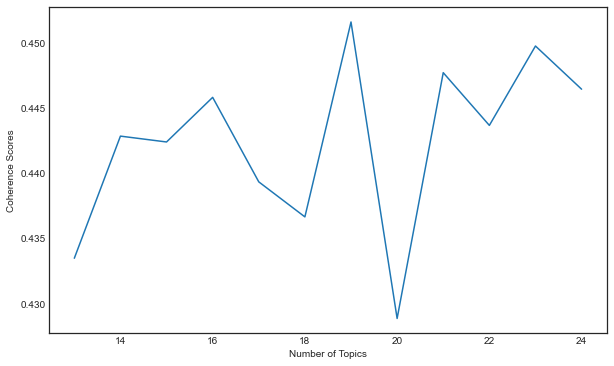

In [ ]:
min_topics, max_topics = 13, 25
coherence_scores=[]
for num_topics in range(min_topics, max_topics):
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model = model, texts=posttrain_bi,dictionary=dictionary)
    coherence_scores.append(coherence.get_coherence())
    print(coherence_scores, num_topics) 


import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

x = [i for i in range(min_topics, max_topics)]

plt.figure(figsize=(10,6))
plt.plot(x, coherence_scores)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Scores')
plt.show()

In [ ]:
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as pyLDAvisgensim

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=19, passes=5, random_state=7 )

pyLDAvis.enable_notebook()
vis=pyLDAvisgensim.prepare(lda_model, corpus, dictionary, sort_topics = False)
pyLDAvis.display(vis)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [ ]:
import pandas as pd
from gensim.models import LdaModel

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=19, passes=5, random_state=7 )
postlda = lda_model.print_topics(num_words=35)
ldamodelpost =pd.DataFrame(postlda)
ldamodelpost.columns =['topic','words']


import re
ldamodelpost['words'] = ldamodelpost['words'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣;!?+ ]"," ")


ldamodelpost.to_csv('postlda19.csv')

C:\Users\mirin\AppData\Local\Temp/ipykernel_13140/886003827.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  ldamodelpost['words'] = ldamodelpost['words'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣;!?+ ]"," ")


### BERT 수행 **불가** : 코드 [붙임 2] 첨부파일에 포함
